In [1]:
import numpy
import h5py
import pandas

from toposample import Config, data
from figure_helper import FigureHelper
from pandas_helper import column_names_to_values
from toposample.db import get_column_from_database
from toposample.data import read_h5_dataset

"""
Main config file. This file specifies the paths to all the result files and allows us to read the results.
"""
cfg = Config("../working_dir_mn_sz50/config/common_config.json")

"""
Additional parameterization, like which examples to plot and in which color
"""
# Which parameters to plot and in which order. We determined them in the Fig 3 notebook
spec_parameters = ['Transitive clustering coefficient', 'Adjacency spectral gap (low)', 'Relative boundary', 'Fourth density coefficient', 'Normalized Betti coefficient', 'Fifth density coefficient', 'Afferent extension rate', 'Out-degree', 'In-degree', 'Efferent extension rate', 'Euler characteristic']
# Related to tribe sizes
spec_size_related = ['Tribe size', 'Mean size']

fig_5d_bar_params = {"width": 0.8}
fig_S11_plot_params = {"marker": '.', "ms": 5,
                      "ls": 'None'}
fig_S11_fit_params = {"ls": '--', "color": 'black'}

"""
To save plots in standardized locations, i.e. under ./figures
"""
fhlpr = FigureHelper()
F = fhlpr("Figure 5")
S11 = fhlpr("Figure S11")

In [2]:
"""
Files we are going to load
"""
tribe_struc_params_fn = cfg._cfg['analyzed']['struc_parameters']
tribe_struc_params_v_fn = cfg._cfg['analyzed']['struc_parameters_volumetric']
tribe_gids_fn = cfg._cfg['analyzed']['tribes']
db_fn = cfg._cfg['analyzed']['database']
tribe_accuracy_fn = cfg._cfg['analyzed']['classifier_components_results']

"""
Load the data
"""
acc_reader = read_h5_dataset("scores")  # Loading function to extract the accuracy

# Values of the topological parameters for all neuron samples
tribe_struc_params = data.TopoData(tribe_struc_params_fn)
vol_struc_params = data.TopoData(tribe_struc_params_v_fn)

# The identifiers of neurons in all neuron samples.
# Used to determine sample sizes and mean values of topol. parameters.
tribe_gids = data.TopoData(tribe_gids_fn)['gids']

# The "database" with topological and functional parameters for all neurons in the model
db = pandas.read_pickle(db_fn)

# Finally, the classification accuracies for all neuron samples
data_acc = data.TopoData(tribe_accuracy_fn, follow_link_functions={"data_fn": (acc_reader, True)})['data_fn']


In [3]:
"""
Some analysis of the data
"""
# The mean accuracy of a sample over the 5-times cross-validation
tribe_nonpooled_mean_acc = data_acc.map(numpy.nanmean)

# The sizes of all neuron samples
tribe_size = tribe_gids.map(len)
# Average for a given type of sample
tribe_mean_size = tribe_size.pool(["index"], func=numpy.mean)
# Add the size of the samples to the data structure holding the other topological and functional parameters
tribe_struc_params.data["Tribe size"] = tribe_size

# Above, we calculated the size of each neuron sample, tribal or volumetric. Now we go one step further:
# For each sample look up the contained neurons, calculate the sizes of their associated tribes and take the mean.
# I.e. the mean size of tribes whose chief is contained in the sample. This gives a measure of the average
# connectedness of the neuron sample.
all_lengths = db["tribe"].apply(len) # Look up tribe size for _all_ tribes in the db
tribe_struc_params.data["Mean size"] =\
tribe_gids.map(lambda x: numpy.mean(all_lengths.loc[x])) # And calculate mean size of contained neurons

vol_struc_params.data["Mean size"] =\
tribe_gids.filter(sampling="Radius").map(lambda x: numpy.mean(all_lengths.loc[x]))

# One additional structural analysis: Some topological parameters are defined as a measurement of the chief
# of a tribe. Since volumetric samples do not have a chief, this is undefined for them.
# Instead, we here calculate the mean value over all neurons in the sample.
vol_struc_params.data["Transitive clustering coefficient"] =\
tribe_gids.filter(sampling="Radius").map(lambda x: numpy.mean(db["trans_cc"].loc[x]))
vol_struc_params.data["In-degree"] =\
tribe_gids.filter(sampling="Radius").map(lambda x: numpy.mean(db["in_degree"].loc[x]))
vol_struc_params.data["Out-degree"] =\
tribe_gids.filter(sampling="Radius").map(lambda x: numpy.mean(db["out_degree"].loc[x]))


In [4]:
from pandas_helper import assemble_result_dataframe, sanitize_param_name
from helper_functions import analyze_linear_fit
from statsmodels.formula.api import ols

"""
We do some more analysis here. Some of the functions we use require data in the form a pandas.Dataframes.
We have a helper function that assembles the data accordingly. Let's build those dataframes!
"""

# Tribe-size related data for the randomly picked tribes
# We need that to generate the "mean size"-based predictor
dframe_random_tribes =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, # Accuracy data
                          tribe_struc_params, # Structural and coupling-related data
                          sampling="M-type", # Which type of sample to look up
                          parameters_to_add=spec_size_related, # Which parameters to add
                          normalize=[])

# Accuracies, topological parameters, tribes-size and coupling-related data for volumetric samples
dframe_vol_coupl =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, tribe_struc_params, sampling="Radius",
                          parameters_to_add=spec_parameters + spec_size_related,
                          normalize=spec_parameters )

# Same, but instead of using the overlap-based "synthetic" parameters, we use the ones that are directly 
# calculated on the samples. Here, we call that the "naive" approach.
dframe_vol_naive =\
assemble_result_dataframe(tribe_nonpooled_mean_acc, vol_struc_params, sampling="Radius",
                          parameters_to_add=spec_parameters + ["Mean size"],
                          normalize=spec_parameters)

# To provide an example of what we got from this
display(dframe_vol_naive)

"""
Now analyze. We fit a linear fit of mean tribe size against accuracy using the random samples, as we did
in the notebook for Figure 4. That is, we use the same fit as before!
"""
model_size = ols("Accuracy ~ Mean_size", data=dframe_random_tribes).fit()

"""
Now that we have a fit, we add the residuals to the dataframes. That is, we subtract the prediction, based
on the fit from the actual accuracy.
"""
dframe_vol_coupl["Accuracy_residual"] = dframe_vol_coupl["Accuracy"] -\
                                        model_size.predict(dframe_vol_coupl)
dframe_vol_naive["Accuracy_residual"] = dframe_vol_naive["Accuracy"] -\
                                        model_size.predict(dframe_vol_naive)

residual_data_vol = analyze_linear_fit(dframe_vol_coupl, spec_parameters,
                                       column_y="Accuracy_residual")
residual_data_vol_naive = analyze_linear_fit(dframe_vol_naive, spec_parameters,
                                            column_y="Accuracy_residual")

/mnt/c/Users/reima/Documents/code/topological_sampling/notebooks/pandas_helper.py:56: RuntimeWarning: invalid value encountered in true_divide
  cols[col_name] = (numpy.array(cols[col_name]) - numpy.nanmean(cols[col_name])) / numpy.nanstd(cols[col_name])


,specifier,Accuracy,Transitive_clustering_coefficient,Adjacency_spectral_gap_low,Relative_boundary,Fourth_density_coefficient,Normalized_Betti_coefficient,Fifth_density_coefficient,Afferent_extension_rate,Outdegree,Indegree,Efferent_extension_rate,Euler_characteristic,Mean_size
0,125 um,0.739340,-1.537230,-1.424531,-1.157055,-0.301961,1.491883,NaN,0.359632,0.872142,1.951130,-1.341177,1.823105,836.361667
1,125 um,0.603356,-1.466001,-0.985569,-1.553597,1.283195,1.698603,NaN,-0.909070,-0.120270,1.572722,-0.304319,2.455554,794.321667
2,125 um,0.470894,-0.803141,-1.350916,-1.262433,-0.301961,1.451949,NaN,-1.706290,2.776533,0.612742,-0.312371,1.601713,797.161667
3,125 um,0.716073,2.918421,-0.941945,-1.915391,-0.301961,0.865264,NaN,-0.178256,-1.098492,-0.957879,-2.777033,1.688578,613.893333
4,125 um,0.475528,-1.371288,1.018391,-1.260529,1.692606,1.594069,NaN,-0.940176,1.069638,1.672675,0.219925,1.873165,826.391667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,325 um,0.849926,0.183688,-1.372728,1.237956,-0.301961,-0.979359,NaN,1.062136,-0.954593,0.067026,0.664548,-0.786926,682.660000
121,325 um,0.832684,0.789201,0.178636,1.343000,0.645144,-0.858968,NaN,1.215569,-0.932537,-0.110863,0.405110,-0.812590,671.518333
122,325 um,0.813589,-0.345666,-0.832886,1.231447,-0.301961,-0.427910,NaN,-0.376425,0.383918,-1.116798,1.221893,-0.903121,639.623333
123,325 um,0.809603,0.492218,-0.164899,1.494743,-0.301961,-0.772639,NaN,1.215219,-1.482841,-0.123287,0.265550,-0.848831,659.593333


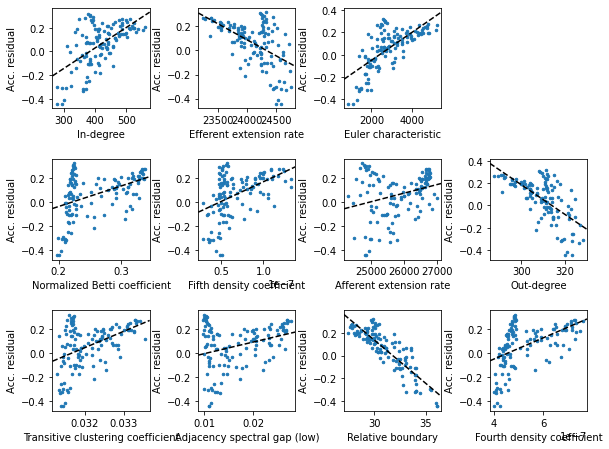

/home/reimann/venvs/topological_sampling/lib/python3.8/site-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  c = np.array(c)


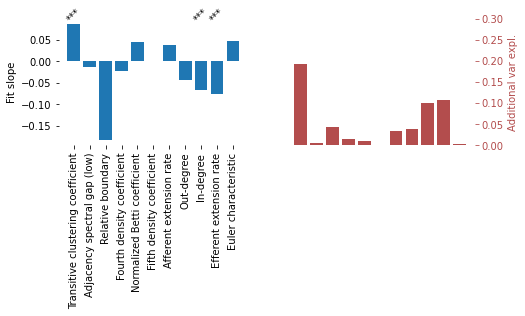

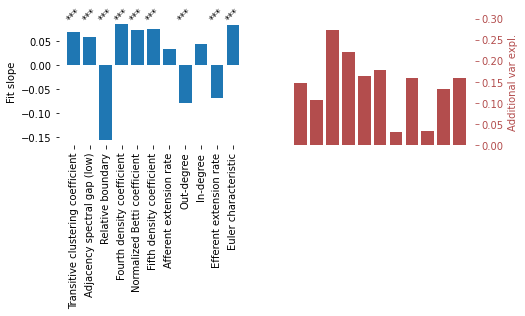

In [10]:
from matplotlib import pyplot as plt
from plot_helpers import plot_linear_fit_results

"""
Figure panel: Synthetic values of topological parameters of vol. samples vs accuracy residuals
"""
fig = plt.figure(figsize=(9, 7))

N = len(spec_parameters)
X = 4
i = 0
for col in spec_parameters:
    col_san = sanitize_param_name(col)
    model = ols("Accuracy_residual ~ {0}".format(col_san), data=dframe_vol_coupl).fit()
    
    pos_x = numpy.mod(i, X); pos_y = numpy.floor(i / X)
    i += 1
    
    ax = fig.add_axes([0.05 + pos_x * 0.225, 0.05 + pos_y * 0.3, 0.15, 0.2])
    ax.plot(dframe_vol_coupl[col_san],
            dframe_vol_coupl["Accuracy_residual"], **fig_S11_plot_params)
    
    xx = ax.get_xlim(); ax.set_xlim(xx)
    ax.plot(xx, model.params["Intercept"] + model.params[col_san] * numpy.array(xx), **fig_S11_fit_params)
    ax.set_xlabel(col)
    ax.set_ylabel("Acc. residual")

S11.save(fig, fn="Panel-A") # Also select 5C from the subpanels

"""
Figure panel: Quality of the fits for the various parameters - for the overlap-based and naive approach
"""
plot_linear_fit_results(residual_data_vol_naive, plot_params=spec_parameters,
                        bar_col="#1f77b3", var_col=[0.7, 0.3, 0.3])

plt.gcf().axes[1].set_ylim([0, 0.3])
F.save(plt.gcf(), fn="Panel-B")

plot_linear_fit_results(residual_data_vol, plot_params=spec_parameters,
                        bar_col="#1f77b3", var_col=[0.7, 0.3, 0.3])
plt.gcf().axes[1].set_ylim([0, 0.3])
F.save(plt.gcf(), fn="Panel-D")